In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy

# py.init_notebook_mode()
%matplotlib inline

## Notations

N: the number of nodes

d: dimension of the feature vectors

i: node index

k: iteration index

$\gamma$: learning rate

## Linear regression problem

We consider the following linear regression problem:

$\min_{x \in \mathbb{R}^d} f(x) := \frac{1}{N}\sum_{i=1}^N f_i(x) \quad$  where  $\quad f_i(x) = \frac{1}{2}\|A_i x - b_i\|^2$

In the above problem, $N$ is the number of nodes, each local cost function $f_i(x)$ is kept by node $i$. Each node can only access its own local cost function $f_i(x)$ and gradient $\nabla f_i(x)$. Each local $A_i \in \mathbb{R}^{m \times d}$  and $b_i \in \mathbb{R}^m$.

#### Generate synthesized data for linear regression

In math, we let $A = [A_1; A_2; \cdots; A_n] \in \mathbb{R}^{Nm\times d}$ and $b = [b_1;b_2;\cdots;b_n] \in \mathbb{R}^{Nm}$. The linear regression problem can be rewritten as

$\min_{x \in \mathbb{R}^d} f(x) := \frac{1}{2N}\|A x - b\|^2.$

The optimal solution can be derived as $x^\star = (A^\top A)^{-1}(A^\top b)$

When we generate data, we directly generate the entire $A$ and $b$. Each local data $A_i$ and $b_i$ can be obtained by retrieving the corresponding block in $A$ and $b$.

In [2]:
def lr_generate_data(total_sample_size, d, x0, noise_scale):
    
    '''
    This function is to generate data (A, b) via b = A*x0 + noise
    Input:
        total_sample_size: size of all samples, i.e., N*m
                        d: variable dimension 
                       x0: an auxilliary variable with dimension d that helps generate b
              noise_scale: controls the scale of noise
    '''
    
    A = np.random.randn(total_sample_size, d) 
    b = A@x0 + noise_scale * np.random.randn(total_sample_size, 1)
    
    return A, b

#### Calculate the optimal solution to the linear regression

The optimal solution can be derived as $x^\star = (A^\top A)^{-1}(A^\top b)$

In [3]:
def get_lr_sol(A, b):
    
    return np.linalg.inv(A.T@A)@(A.T@b)

#### Test utilities to generate data and get solution

In [4]:
N, m, d = 10, 5, 5
total_sample_size = N * m
x0 = np.random.randn(d, 1)
noise_scale = 0.1

# Generate data
A, b = lr_generate_data(total_sample_size, d, x0, noise_scale)

# Get optimal solution
x_star = get_lr_sol(A, b)

# Test the optimality of x_star
grad = A.T@(A@x_star - b)
if(np.linalg.norm(grad) <= 1e-10):
    print("x_star is the optimal solution")
else:
    print("x_star is not the optimal solution")

x_star is the optimal solution


## FedAvg algorithm

#### A standard algorithmic recursion

Recall the following linear regression problem:

$\min_{x \in \mathbb{R}^d} f(x) := \frac{1}{N}\sum_{i=1}^N f_i(x) \quad$  where  $\quad f_i(x) = \frac{1}{2}\|A_i x - b_i\|^2$

The FedAvg algorithm is as follows:

$\psi_i^{(k)} = x_i^{(k)} - \gamma \nabla f(x_i^{(k)})$ for all node $i$ in parallel

$x_i^{(k+1)} = (1/n)\sum_{i=1}^n \psi_i^{(k)}$ if $\mathrm{mod}(k, \tau) = 0$ otherwise $x_i^{(k+1)} = \psi_i^{(k)}$

where $\tau$ is the number of local updates

#### Rewrite the algorithm in a more compact manner

Generally speaking, simulating the algorithm in a real distributed manner is resource consuming, and here we only validate the convergence performance of the FedAvg algorithm rather than its wall-clock performance. To this end, we introduce

$X = [x_1^\top; x_2^\top; \cdots; x_N^\top] \in \mathbb{R}^{N \times d}$

$\Psi = [\psi_1^\top; \psi_2^\top; \cdots; \psi_N^\top] \in \mathbb{R}^{N \times d}$

$G = [(\nabla f_1(x_1))^\top; (\nabla f_2(x_2))^\top; \cdots; (\nabla f_N(x_N))^\top] \in \mathbb{R}^{N \times d}$

With the above notations, we can rewrite the FedAvg algorithm as follows

$X^{(k+1)} = W\left( X^{(k)} - \gamma G^{(k)} \right)$

where

$ W = \left\{
\begin{array}{ll}
I & \mbox{if $\mathrm{mod}(k,\tau) \neq 0$} \\
(1/n)\mathbf{1}_n \mathbf{1}_n^\top & \mbox{if $\mathrm{mod}(k,\tau) = 0$}
\end{array}
\right.
$

#### Implementing the FedAvg algorithm

In [5]:
def get_G(A, b, X, N, d):
    
    '''
    This function is to get the gradient matrix G which is defined above
    X : the variable matrix X which is defined above
    '''
    
    total_sample_size, _ = A.shape
    local_sample_size    = total_sample_size // N
    
    G = np.zeros((N, d))
    for i in range(N):
        
        Ai = A[i*local_sample_size:(i+1)*local_sample_size,:]
        bi = b[i*local_sample_size:(i+1)*local_sample_size,:]
        xi = X[i,:].reshape(-1,1)
        grad = Ai.T@(Ai@xi - bi)
        G[i,:] = grad.reshape(1,-1)
        
    return G

In [6]:
def FedAvg(A, b, x_star, tau, N, d, gamma, num_iters):
    
    '''
    This function is to implement the FedAvg algorithm
    x_star    : the optimal solutioin. We use it as the reference solution
    tau       : the local update period
    gamma     : learning rate
    num_iters : the number of FedAvg iterations
    '''
    
    X = np.zeros((N, d))
    error = np.zeros(num_iters)
    
    for ite in range(num_iters):
        
        # decide whether to conduct local update or to global averaging
        if ite%tau == 0:
            W = np.ones((N, N))/N
        else:
            W = np.eye(N)
            
        # FedAvg main recursion
        G   = get_G(A, b, X, N, d)
        Phi = X - gamma * G
        X   = W@Phi
        
        # record the error
        error[ite] = np.linalg.norm(X - x_star.reshape(1,-1))/N
        
    return error

## FedAvg cannot converge to the optimal solution

In [7]:
N, m, d = 10, 5, 5
total_sample_size = N * m
x0 = np.random.randn(d, 1)
noise_scale = 0.1

# Generate data
A, b   = lr_generate_data(total_sample_size, d, x0, noise_scale)

# Get optimal solution
x_star = get_lr_sol(A, b)

# Test the optimality of x_star
grad = A.T@(A@x_star - b)
if(np.linalg.norm(grad) <= 1e-10):
    print("x_star is the optimal solution")
else:
    print("x_star is not the optimal solution")

x_star is the optimal solution


In [8]:
error = FedAvg(A, b, x_star = x_star, tau = 10, N = N, d = d, gamma = 0.01, num_iters = 400)

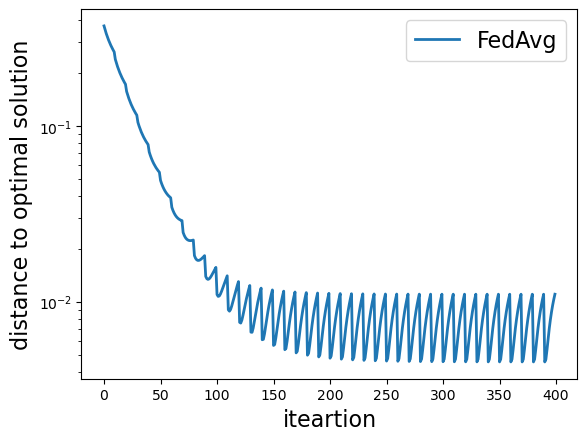

In [9]:
plt.semilogy(error, linewidth = 2.0)
plt.xlabel('iteartion', fontsize = 16)
plt.ylabel('distance to optimal solution', fontsize = 16)
plt.legend(['FedAvg'], fontsize = 16)

It is observed that FedAvg oscillates and cannot converge to the optimal solution.

It is because FedAvg suffers from data heterogeneity

## My cool algorithm

Recall the FedAvg recursion: 
    
$X^{(k+1)} = W\left( X^{(k)} - \gamma G^{(k)} \right)$

It is very similar to the decentralized gradient descent (DGD) algorithm but with a time-varying mixing matrix

$ W = \left\{
\begin{array}{ll}
I & \mbox{if $\mathrm{mod}(k,\tau) \neq 0$} \\
(1/N)\mathbf{1}_N \mathbf{1}_N^\top & \mbox{if $\mathrm{mod}(k,\tau) = 0$}
\end{array}
\right.
$

This inspires us to correct the data heterogeneity suffered in FedAvg by utilizing the techniques in decentralized optimization. Check the corresponding lecture slides for decentralized optimization

### My cool algorithm

Please write down the math recursions of your cool algorithm below:

[Write down the algorithm recursion here]

In [13]:
# Please implement your cool algorithm here
def MyCoolAlg(A, b, x_star, tau, N, d, gamma, num_iters):
    
    '''
    This function is to implement the Fully-ATC algorithm
    x_star    : the optimal solutioin. We use it as the reference solution
    tau       : the local update period
    gamma     : learning rate
    num_iters : the number of FedAvg iterations
    '''
    
    X = np.zeros((N, d))
    error = np.zeros(num_iters)
    
    G = get_G(A, b, X, N, d)
    Y = G
    for ite in range(num_iters):
        
        # decide whether to conduct local update or to global averaging
        if ite%tau == 0:
            W = np.ones((N, N))/N
        else:
            W = np.eye(N)
            
        # FedAvg main recursion
        Phi = X - gamma * Y
        X   = W@Phi
        G_  = get_G(A, b, X, N, d)
        Y   = W@(Y + G_ - G)
        G   = G_
        
        # record the error
        error[ite] = np.linalg.norm(X - x_star.reshape(1,-1))/N
        
    return error

### Compare my cool algorithm with FedAvg

In [14]:
N, m, d = 10, 5, 5
total_sample_size = N * m
x0 = np.random.randn(d, 1)
noise_scale = 0.1

# Generate data
A, b   = lr_generate_data(total_sample_size, d, x0, noise_scale)

# Get optimal solution
x_star = get_lr_sol(A, b)

# Test the optimality of x_star
grad = A.T@(A@x_star - b)
if(np.linalg.norm(grad) <= 1e-10):
    print("x_star is the optimal solution")
else:
    print("x_star is not the optimal solution")

x_star is the optimal solution


In [15]:
tau = 10
gamma = 0.01
num_iters = 1000

error_fedavg  = FedAvg(A, b, x_star = x_star, tau = tau, N = N, d = d, gamma = gamma, num_iters = num_iters)
error_coolalg = MyCoolAlg(A, b, x_star = x_star, tau = tau, N = N, d = d, gamma = gamma, num_iters = num_iters)

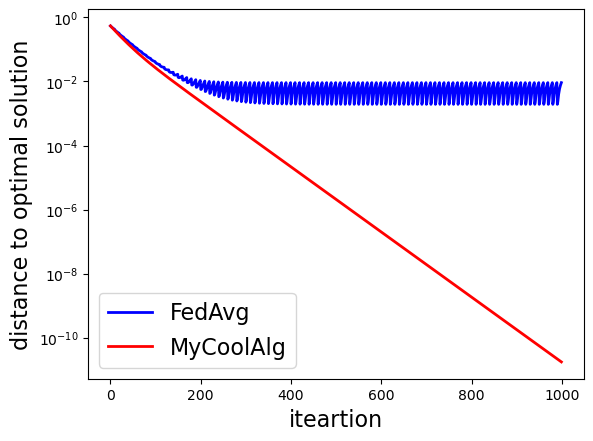

In [16]:
plt.semilogy(np.arange(num_iters), error_fedavg, 'b-', np.arange(num_iters), error_coolalg, 'r-', linewidth = 2.0)
plt.xlabel('iteartion', fontsize = 16)
plt.ylabel('distance to optimal solution', fontsize = 16)
plt.legend(['FedAvg', 'MyCoolAlg'], fontsize = 16)

You should be able to observe that your new algorithm will converge with accuracy better than 1e-10

In [17]:
if error_coolalg[-1] < 1e-10:
    print("Congratulations! Your cool algorithm has corrected the data heterogeneity suffered by FedAvg! If you can further provide convergence analyses, you may wrap them into a paper and submit it to a good conference or jounral :)")
else:
    print("Please try again")

Congratulations! Your cool algorithm has corrected the data heterogeneity suffered by FedAvg! If you can further provide convergence analyses, you may wrap them into a paper and submit it to a good conference or jounral :)
